In [1]:
import torch
from torch.autograd import Variable

## Get a state of the double integrator

<p align="center">
  <img src="double_integrator_brick.svg" width="350"/>
</p>

In [2]:
### initial state and parameters

## parameters
width  = 10.0 # width of brick in pixels
height = 5.0
t_f = 100     # number of time steps

## state
x    = 30.0 # position to right in pixels
xdot = 0.0  # 

state_initial = torch.FloatTensor([x, xdot])
state_initial = Variable(state_initial, requires_grad=False)
print state_initial

Variable containing:
 30
  0
[torch.FloatTensor of size 2]



## Just render double integrator

- Convert state of double integrator to an AABB list of corners in img
- Find all pixels inside AABB

In [3]:
import numpy as np
pi = np.pi

def convert_world_to_img_coordinates(world_coordinates):
    return world_coordinates + 50

def torch_flip(two_element_tensor):
    return torch.FloatTensor([two_element_tensor[1],two_element_tensor[0]])
    
def torch_det(A,B):
    return A[0]*B[1] - A[1]*B[0]

def distance_pytorch(A, B, P):
    if (A == B).all() or (B == P).all():
        return 0
    if (torch.acos(torch.FloatTensor([torch.dot((P - A) / (P - A).norm(), 
                                                (B - A) / (B - A).norm())])) > pi/2).all():
        return (P - A).norm()
    
    if (torch.acos(torch.FloatTensor([torch.dot((P - B) / (P - B).norm(), 
                                                (A - B) / (A - B).norm())])) > pi/2).all():
        return (P - B).norm()
    
    return abs(torch_det(A-B, A-P))/(B-A).norm()

def inside_aabb(aabb_corners, P):
    # check x conditions
    if (P[0] < aabb_corners[0][0]).all() or (P[0] > aabb_corners[3][0]).all():
        return False
    
    # check y conditions
    if (P[1] < aabb_corners[0][1]).all() or (P[1] > aabb_corners[3][1]).all():
        return False
    
    return True

def distance_to_aabb(aabb_corners, P):
    # if inside aabb, return 0
    distance_to_left   = distance_pytorch(aabb_corners[0], aabb_corners[1], P)
    distance_to_top    = distance_pytorch(aabb_corners[1], aabb_corners[3], P)
    distance_to_right  = distance_pytorch(aabb_corners[0], aabb_corners[1], P)
    distance_to_bottom = distance_pytorch(aabb_corners[0], aabb_corners[1], P) 

0.000482082366943  seconds for state to img


<IPython.core.display.Javascript object>


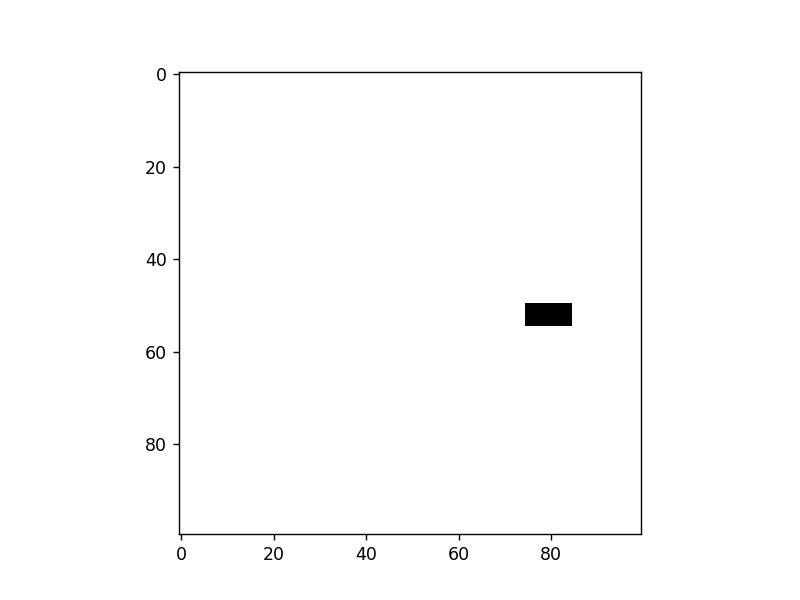

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

def where(cond, x_1, x_2):
    cond = cond.float()    
    return (cond * x_1) + ((1-cond) * x_2)

def vectorized_inside_aabb(aabb_corners):
    img = Variable(torch.ones((100,100)), requires_grad=False)
    img[0:int(aabb_corners[0][0]),:] = 0.0
    img[int(aabb_corners[3][0]):,:] = 0.0
    img[:,0:int(aabb_corners[0][1])] = 0.0
    img[:,int(aabb_corners[3][1]):] = 0.0
    return img
    
def double_integrator_state_to_img(state):
    center = Variable(torch.zeros(2), requires_grad = False)
    center[1] = state[0]
    center_in_img = convert_world_to_img_coordinates(center)

    lower_left  = center + Variable(torch.FloatTensor([0,      -width/2]), requires_grad=False)
    upper_left  = center + Variable(torch.FloatTensor([height, -width/2]), requires_grad=False)
    lower_right = center + Variable(torch.FloatTensor([0,       width/2]), requires_grad=False)
    upper_right = center + Variable(torch.FloatTensor([height,  width/2]), requires_grad=False)

    corners = [lower_left, upper_left, lower_right, upper_right]
    corners_in_img = [convert_world_to_img_coordinates(x) for x in corners]
    
    return vectorized_inside_aabb(corners_in_img)

import time; start = time.time()
img = double_integrator_state_to_img(state_initial)
print time.time() - start, " seconds for state to img"
plt.imshow(img.data, cmap=plt.get_cmap('gray_r'))
plt.show()

## State feedback: perform state feedback with just PD

In [5]:
def pd_origin_controller(state):
    x_desired = 0
    xdot_desired = 0
    diff_pos = (x_desired    - state[0])
    diff_vel = (xdot_desired - state[1])
    u = 1000*diff_pos + 100*diff_vel
    if (u > 500).all():
        u = u*0 + 500  # this trick mantains u as a Variable
    if (u < -500).all():
        u = u*0 -500
    return u

def double_integrator_next_state(state, u):
    deriv = Variable(torch.zeros(2), requires_grad = False)
    deriv[0] = state[1]
    deriv[1] = u
    dt = .01
    next_state = state + deriv*dt
    return next_state

state_tape = []
state_tape.append(state_initial)

for i in range(t_f):
    u = pd_origin_controller(state_tape[-1])
    next_state = double_integrator_next_state(state_tape[-1],u)
    state_tape.append(next_state)
    
print len(state_tape)

101


## Convert states to imgs

In [6]:
img_tape = []

for i in state_tape:
    img_tape.append(double_integrator_state_to_img(i))
    
print len(img_tape)

101


## Visualize

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from IPython.display import HTML

def get_animation(img_tape):
    fig = plt.figure()
    first_img = img_tape[0].data
    im = plt.imshow(first_img, cmap='gist_gray_r')

    def init():
        im.set_data(first_img)

    def animate(i):
        im.set_data(img_tape[i].data)
        return im

    animate = animation.FuncAnimation(fig, animate, init_func=init, frames=len(img_tape), interval=20, blit=True)
    plt.close(fig)
    return animate
    
# ani = get_animation(img_tape)
# HTML(ani.to_html5_video())

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [25]:
x_i = Variable(torch.FloatTensor([1.0, 1.1]), requires_grad=True)
print x_i

P = Variable(torch.FloatTensor([1, 1]), requires_grad=True)
print P
### Step 1: compute V(x)
def compute_V(x):
    '''V(x) = x_1^2 + x_2^2'''
    x_squared = x.pow(2)
    return torch.dot(P, x_squared)

print x_i.shape
print compute_V(x_i)

many_x_i = Variable(torch.FloatTensor([[1.0, 1.1],[1.1, 2.2]]), requires_grad=True)

def compute_V_vectorized(x):
    x_squared = x.pow(2)
    print P.unsqueeze(1).shape
    print x.shape
    P_transpose = torch.t(P.unsqueeze(1))
    return P_transpose.mm(x)

print many_x_i
print compute_V_vectorized(many_x_i)

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]

torch.Size([2])
Variable containing:
 2.2100
[torch.FloatTensor of size 1]

Variable containing:
 1.0000  1.1000
 1.1000  2.2000
[torch.FloatTensor of size 2x2]

torch.Size([2, 1])
torch.Size([2, 2])
Variable containing:
 2.1000  3.3000
[torch.FloatTensor of size 1x2]



In [8]:


### Step 2: compute dV/dx

### Step 3: initialize policy parameters
K = Variable(torch.FloatTensor([1, 2]), requires_grad=True)
print K

### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2))
    xdot[0] = x[1]
    xdot[1] = -torch.dot(K,x)
    return xdot
    
xdot = dynamics(x_i)
print xdot

### Step 5: compute Vdot

def compute_Vdot(x):
    V = compute_V(x)
    V.backward(torch.FloatTensor([1.0]),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
    f = dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot
    
Vdot = compute_Vdot(x_i)
print Vdot
Vdot.backward()

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
[torch.FloatTensor of size 2]

Variable containing:
 1
 2
[torch.FloatTensor of size 2]

Variable containing:
 1.1000
-3.2000
[torch.FloatTensor of size 2]

Variable containing:
-4.8400
[torch.FloatTensor of size 1]



## First let's verify, no synthesis
 
K = [1, 2] and P = [1, 1] should be stable

In [9]:
K = Variable(torch.FloatTensor([1, 2]), requires_grad=True)
P = Variable(torch.FloatTensor([1, 1]), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

## Now let's search for K, from an initialization not stable

In [10]:
P = Variable(torch.rand(2), requires_grad=True)
K = Variable(torch.randn(2), requires_grad=True)

print "Initial P", P
print "Initial K", K


for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

Initial P Variable containing:
 0.6887
 0.0849
[torch.FloatTensor of size 2]

Initial K Variable containing:
-0.3209
-1.1270
[torch.FloatTensor of size 2]

false, counterexample found:  Variable containing:
-2.4033
-1.0704
[torch.FloatTensor of size 2]



<IPython.core.display.Javascript object>


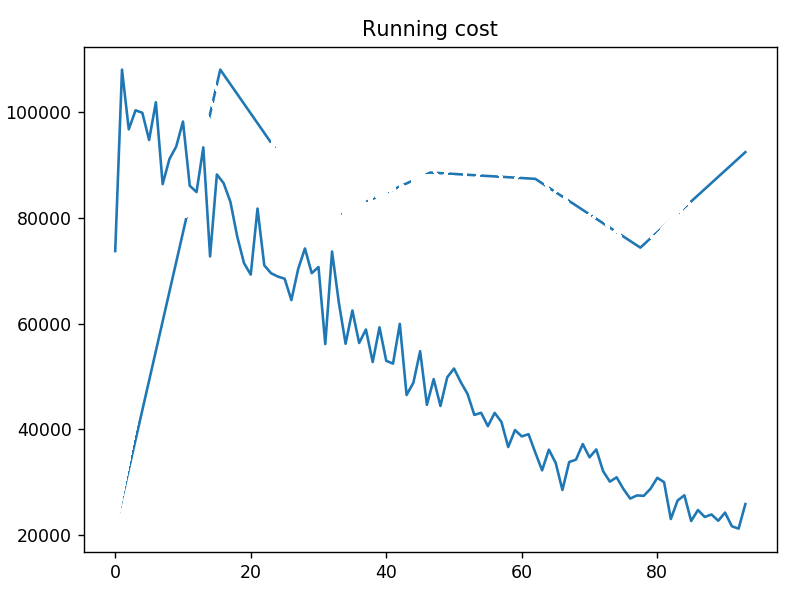

In [20]:
## optimization plotting tool

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [21]:
## optimize

num_iterations = 1000
num_samples_per_iteration = 1000
step_rate = 1e-7

# K has already been initialized above, and initial policy visualized

import time
print "first P is", P
print "first K is", K

for cost_iteration in range(num_iterations):
    
    start = time.time()
    
    cost = 0
    
    for i in range(1000):
        x_i = Variable(torch.randn(2)*10, requires_grad=True)
        Vdot = compute_Vdot(x_i)
        cost += Vdot.clamp(min=0)
        
    ## Automatically differentiate
    cost.backward()

    # Update K via gradient descent
    K.data -= step_rate * K.grad.data
    P.data -= step_rate * P.grad.data
    
    # Project P into feasible
    P.data = torch.abs(P.data)
    # Make P numerically stable by normalizing
    P.data = P.data/P.data.sum()
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    P.grad.data.zero_()
    
    print time.time() - start, "is time for one step of grad descent"
    print 
    print cost.data[0]
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 1 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print "P is", P
    print "K is", K

first P is Variable containing:
 0.1069
 0.7304
[torch.FloatTensor of size 2]

first K is Variable containing:
-1.4638
-0.0798
[torch.FloatTensor of size 2]

0.365760087967 is time for one step of grad descent

73762.7265625
P is Variable containing:
 0.1201
 0.8799
[torch.FloatTensor of size 2]

K is Variable containing:
-1.4596
-0.0723
[torch.FloatTensor of size 2]

0.341505050659 is time for one step of grad descent

108120.484375
P is Variable containing:
 0.1122
 0.8878
[torch.FloatTensor of size 2]

K is Variable containing:
-1.4532
-0.0630
[torch.FloatTensor of size 2]

0.382987976074 is time for one step of grad descent

96816.9921875
P is Variable containing:
 0.1035
 0.8965
[torch.FloatTensor of size 2]

K is Variable containing:
-1.4475
-0.0543
[torch.FloatTensor of size 2]

0.362282037735 is time for one step of grad descent

100417.179688
P is Variable containing:
 0.0951
 0.9049
[torch.FloatTensor of size 2]

K is Variable containing:
-1.4414
-0.0446
[torch.FloatTensor of

0.379289150238 is time for one step of grad descent

52745.1484375
P is Variable containing:
 0.0061
 0.9939
[torch.FloatTensor of size 2]

K is Variable containing:
-1.2198
 0.2667
[torch.FloatTensor of size 2]

0.336069107056 is time for one step of grad descent

59326.9765625
P is Variable containing:
 0.0047
 0.9953
[torch.FloatTensor of size 2]

K is Variable containing:
-1.2134
 0.2737
[torch.FloatTensor of size 2]

0.280870914459 is time for one step of grad descent

52973.5429688
P is Variable containing:
 0.0053
 0.9947
[torch.FloatTensor of size 2]

K is Variable containing:
-1.2076
 0.2804
[torch.FloatTensor of size 2]

0.313446044922 is time for one step of grad descent

52453.03125
P is Variable containing:
 0.0045
 0.9955
[torch.FloatTensor of size 2]

K is Variable containing:
-1.2015
 0.2880
[torch.FloatTensor of size 2]

0.34014415741 is time for one step of grad descent

59980.2851562
P is Variable containing:
 0.0059
 0.9941
[torch.FloatTensor of size 2]

K is Variab

0.308068037033 is time for one step of grad descent

27483.28125
P is Variable containing:
 0.0043
 0.9957
[torch.FloatTensor of size 2]

K is Variable containing:
-0.9991
 0.4968
[torch.FloatTensor of size 2]

0.390011072159 is time for one step of grad descent

27408.4511719
P is Variable containing:
 0.0059
 0.9941
[torch.FloatTensor of size 2]

K is Variable containing:
-0.9942
 0.5012
[torch.FloatTensor of size 2]

0.33821606636 is time for one step of grad descent

28745.9003906
P is Variable containing:
 0.0039
 0.9961
[torch.FloatTensor of size 2]

K is Variable containing:
-0.9891
 0.5056
[torch.FloatTensor of size 2]

0.305523872375 is time for one step of grad descent

30818.3203125
P is Variable containing:
 0.0062
 0.9938
[torch.FloatTensor of size 2]

K is Variable containing:
-0.9836
 0.5104
[torch.FloatTensor of size 2]

0.375586032867 is time for one step of grad descent

30000.21875
P is Variable containing:
 0.0044
 0.9956
[torch.FloatTensor of size 2]

K is Variable

KeyboardInterrupt: 

In [13]:
print K
print P

Variable containing:
 0.6324
 0.5807
[torch.FloatTensor of size 2]

Variable containing:
 0.3884
 0.6116
[torch.FloatTensor of size 2]



## Analytical double integrator Lyapunov

$$x = 
       \begin{bmatrix} x_1 \\ x_2
        \end{bmatrix} $$

$$\dot{x} = f(x,u) =
       \begin{bmatrix} x_2 \\ u
        \end{bmatrix} $$
        
Policy

$$ u = \pi_K(x) = -K^Tx = - k_1x_1 - k_2x_2$$
        
Lyapunov

$$V(x) = P^Tx = p_1x_1^2 + p_2x_2^2 = \text{p.s.d. by construction}$$

$$\dot{V}(x) = \bigg[ \frac{\partial V}{\partial x}\bigg]^T \big[f(x,\pi_K(x) \big] $$

$$ = \begin{bmatrix} 2p_1x_1 \\ 2p_2x_2
        \end{bmatrix}^T \begin{bmatrix} x_2 \\ -k_1x_1 - k_2x_2
        \end{bmatrix} $$
        
$$ =  2p_1x_1x_2 + 2p_2x_2( - k_1x_1 - k_2x_2) $$

$$ =  2p_1x_1x_2 - 2p_2k_1x_1x_2 - 2p_2k_2x_2^2 $$

We need both terms to be negative semidefinite:

$$ =  2x_1x_2(p_1 - p_2k_1 ) - 2p_2k_2x_2^2 $$

Therefore conditions are:

a) $p_1 = p_2k_1$

b) $k_2 > 0$ ($p_2$ already must be $> 0$) 

In [15]:
# condition (a):  p_1 - p_2*k_1
print P[0] - P[1]*K[0]

# condition (b): k_2 > 0
print K[1]


Variable containing:
1.00000e-03 *
  1.5587
[torch.FloatTensor of size 1]

Variable containing:
 0.5807
[torch.FloatTensor of size 1]



In [20]:
# Note: first time I ended up with these values:

# print K
# print P
# Variable containing:
#   0.2410
#  16.2734
# [torch.FloatTensor of size 2]

# Variable containing:
#  0.3484
#  0.8831
# [torch.FloatTensor of size 2]

#Which gave only:

# # condition (a):  p_1 - p_2*k_1
# print P[0] - P[1]*K[0]

# # condition (b): k_2 > 0
# print K[1]

# Variable containing:
#  0.1356
# [torch.FloatTensor of size 1]

# Variable containing:
#  16.2734
# [torch.FloatTensor of size 1]

# But this was Vdot negative semidefinite over all samples, since k_2 was so large it could outweigh the first term

In [14]:
state_tape = []
state_tape.append(state_initial)

for i in range(1000):
    u = dynamics(state_tape[-1])[1]
    next_state = double_integrator_next_state(state_tape[-1],u)
    state_tape.append(next_state)
    
print len(state_tape)
img_tape = []

for i in state_tape:
    img_tape.append(double_integrator_state_to_img(i))
    
print len(img_tape)

1001
1001


<IPython.core.display.Javascript object>


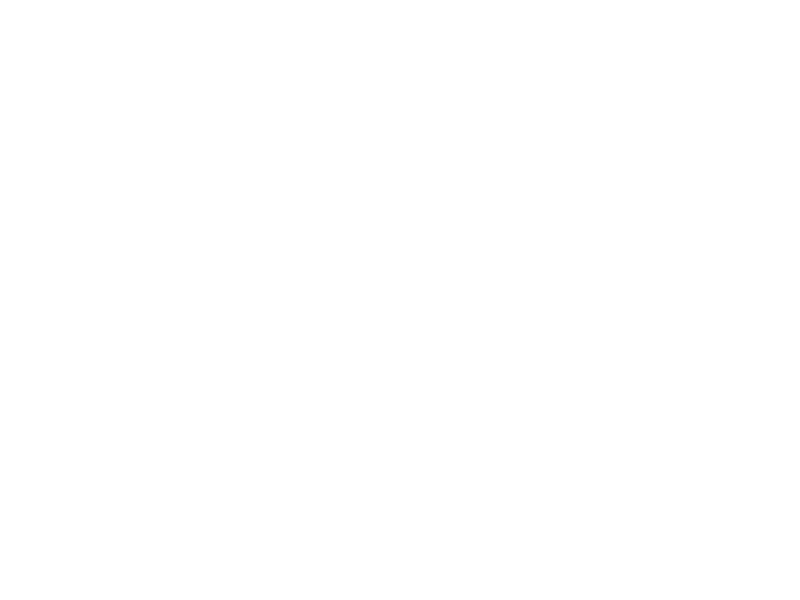

In [15]:
    
ani = get_animation(img_tape)
HTML(ani.to_html5_video())